In [688]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import imghdr

In [689]:
import cv2

In [690]:
data_dir = "data"
image_extensions = ["jpeg", "jpg", "bmp", "png"] #List of allowed extensions

In [691]:
os.listdir(data_dir)

['horse', 'dog', 'butterfly', 'cat']

In [692]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_extensions: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)



Loading our data

In [693]:
data = tf.keras.utils.image_dataset_from_directory("data")
#Builds us the dataset and does some preprocessing

Found 257 files belonging to 4 classes.


In [694]:
#The data is a generator so we will convert it to a numpy iterator
data_iterator = data.as_numpy_iterator()

#We will get consecutive batches from .next()

In [695]:
batch = data_iterator.next()
batch

(array([[[[1.15000000e+02, 1.47000000e+02, 4.00000000e+01],
          [1.15000000e+02, 1.47000000e+02, 4.00000000e+01],
          [1.15000000e+02, 1.47000000e+02, 4.00000000e+01],
          ...,
          [1.15000000e+02, 1.47000000e+02, 4.00000000e+01],
          [1.15000000e+02, 1.47000000e+02, 4.00000000e+01],
          [1.15000000e+02, 1.47000000e+02, 4.00000000e+01]],
 
         [[1.15000000e+02, 1.47000000e+02, 4.00000000e+01],
          [1.15000000e+02, 1.47000000e+02, 4.00000000e+01],
          [1.15000000e+02, 1.47000000e+02, 4.00000000e+01],
          ...,
          [1.15000000e+02, 1.47000000e+02, 4.00000000e+01],
          [1.15000000e+02, 1.47000000e+02, 4.00000000e+01],
          [1.15000000e+02, 1.47000000e+02, 4.00000000e+01]],
 
         [[1.15000000e+02, 1.47000000e+02, 4.00000000e+01],
          [1.15000000e+02, 1.47000000e+02, 4.00000000e+01],
          [1.15000000e+02, 1.47000000e+02, 4.00000000e+01],
          ...,
          [1.15000000e+02, 1.47000000e+02, 4.0000

In [696]:
len(batch) #the images and the labels


2

In [697]:
batch[0].shape #We have to index the 0 as we want the shape of the images batch[1] wil refer to the labels

(32, 256, 256, 3)

In [698]:
batch[1]

array([0, 0, 1, 0, 1, 1, 3, 2, 0, 0, 3, 0, 0, 3, 3, 1, 2, 1, 3, 0, 1, 0,
       1, 1, 2, 1, 1, 2, 1, 2, 2, 2], dtype=int32)

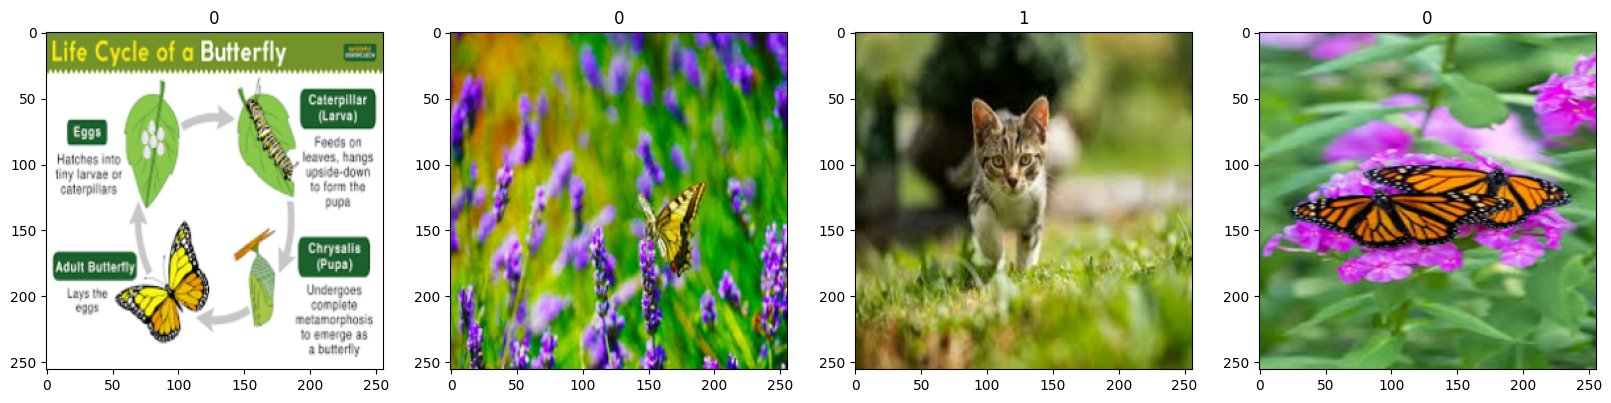

In [699]:
fig, ax = plt.subplots(ncols = 4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

Preprocessing our data

In [700]:
data = data.map(lambda x,y: (x/tf.reduce_max(x), y))
#Every time we fetch our data from the pipeline, it will scale our data between 0 and 1

In [701]:
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()

In [702]:
batch[0].max()

np.float32(1.0)

Splitting our data 

In [703]:
len(data) # no of batches

9

In [704]:
train_size = int(len(data) * .7)
val_size = int(len(data) * .2) + 1
test_size = int(len(data) * .1) + 1 #Adding a one so all batches are used

train_size, val_size, test_size

(6, 2, 1)

In [705]:
#Our data has already been shuffled so we aren't shuffling it here
train_data = data.take(train_size)
val_data = data.skip(train_size).take(val_size)
test_data = data.skip(train_size + val_size).take(test_size)

In [706]:
len(train_data), len(val_data), len(test_data)

(6, 2, 1)

Building the deep learning model

In [707]:
model = tf.keras.Sequential()

In [708]:
#16 filters, kernal_size = (3,3) stride = 1, stride is how many pixels it moves over at once
model.add(tf.keras.layers.Conv2D(16, (3,3), 1, activation="relu", input_shape=(256,256,3)))
model.add(tf.keras.layers.MaxPooling2D()) #returns back the max value that we get from our convolution

model.add(tf.keras.layers.Conv2D(32, (3,3), 1, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(16, (3,3), 1, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256, activation="relu"))
model.add(tf.keras.layers.Dense(4, activation="softmax"))

/home/varshaan/image-classification/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [709]:
model.compile("adam", loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])

In [710]:
model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_56 (Conv2D)              │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_54 (MaxPooling2D) │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,697,396 (14.10 MB)

 Trainable params: 3,697,396 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [711]:
logdir = "logs"

In [712]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [713]:
history = model.fit(train_data, epochs = 15, validation_data= val_data, callbacks=[tensorboard_callback])

Epoch 1/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - accuracy: 0.1986 - loss: 4.3886 - val_accuracy: 0.2656 - val_loss: 1.5328
Epoch 2/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - accuracy: 0.2409 - loss: 1.4928 - val_accuracy: 0.3125 - val_loss: 1.3622
Epoch 3/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - accuracy: 0.3757 - loss: 1.3604 - val_accuracy: 0.5625 - val_loss: 1.3152
Epoch 4/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - accuracy: 0.4529 - loss: 1.2834 - val_accuracy: 0.5625 - val_loss: 1.1534
Epoch 5/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 186ms/step - accuracy: 0.4501 - loss: 1.1419 - val_accuracy: 0.5625 - val_loss: 1.0415
Epoch 6/15


2025-07-15 16:43:23.215018: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - accuracy: 0.6019 - loss: 1.0221 - val_accuracy: 0.5625 - val_loss: 1.1018
Epoch 7/15


2025-07-15 16:43:24.407011: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - accuracy: 0.5655 - loss: 1.0036 - val_accuracy: 0.6562 - val_loss: 0.9337
Epoch 8/15


2025-07-15 16:43:25.745438: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 270ms/step - accuracy: 0.6751 - loss: 0.9252 - val_accuracy: 0.6875 - val_loss: 0.8226
Epoch 9/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 253ms/step - accuracy: 0.7095 - loss: 0.8011 - val_accuracy: 0.6250 - val_loss: 0.7994
Epoch 10/15
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 247ms/step - accuracy: 0.7195 - loss: 0.7447 - val_accuracy: 0.7969 - val_loss: 0.6079
Epoch 11/15


2025-07-15 16:43:30.508363: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-07-15 16:43:30.706154: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - accuracy: 0.7370 - loss: 0.6903 - val_accuracy: 0.8438 - val_loss: 0.6261
Epoch 12/15


2025-07-15 16:43:31.973853: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-07-15 16:43:32.157155: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 230ms/step - accuracy: 0.7496 - loss: 0.6623 - val_accuracy: 0.7969 - val_loss: 0.5863
Epoch 13/15


2025-07-15 16:43:33.375984: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 237ms/step - accuracy: 0.8281 - loss: 0.5761 - val_accuracy: 0.7969 - val_loss: 0.5272
Epoch 14/15


2025-07-15 16:43:34.861329: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


1/6 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step - accuracy: 0.8750 - loss: 0.4509

2025-07-15 16:43:35.068538: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step - accuracy: 0.8022 - loss: 0.5446 - val_accuracy: 0.8750 - val_loss: 0.4357
Epoch 15/15


2025-07-15 16:43:36.315274: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size
2025-07-15 16:43:36.500790: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.8528 - loss: 0.4976

2025-07-15 16:43:37.711030: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 25165952 bytes after encountering the first element of size 25165952 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - accuracy: 0.8463 - loss: 0.5024 - val_accuracy: 0.8594 - val_loss: 0.3904


In [727]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

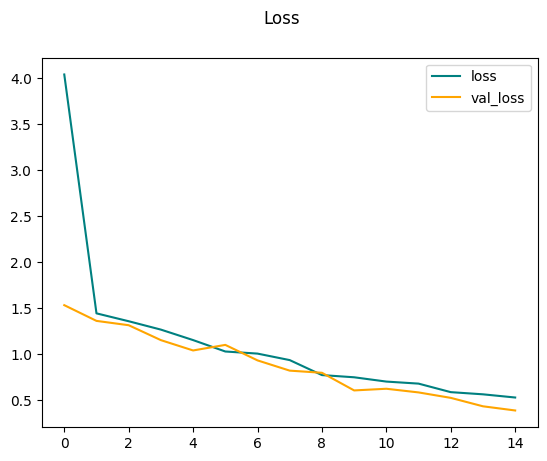

In [728]:
fig = plt.figure()
plt.plot(history.history["loss"], color="teal", label="loss")
plt.plot(history.history["val_loss"], color="orange", label="val_loss")
fig.suptitle("Loss")
plt.legend()
plt.show()

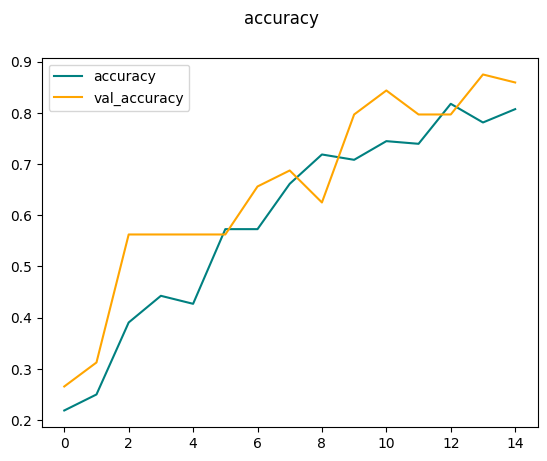

In [729]:
fig = plt.figure()
plt.plot(history.history["accuracy"], color="teal", label="accuracy")
plt.plot(history.history["val_accuracy"], color="orange", label="val_accuracy")
fig.suptitle("accuracy")
plt.legend()
plt.show()

In [730]:
from tensorflow.keras.metrics import Precision, Recall

In [731]:
precision = Precision()
recall = Recall()

In [732]:
len(test_data)

1

In [733]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    y_pred = model.predict(X)
    y_pred_classes = tf.argmax(y_pred, axis=1)
    precision.update_state(y, y_pred_classes)
    recall.update_state(y, y_pred_classes)

    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


In [734]:
print("precision:", precision.result().numpy(), "recall", recall.result().numpy(), "acc", acc.result().numpy())

precision: 1.0 recall 1.0 acc 1.0


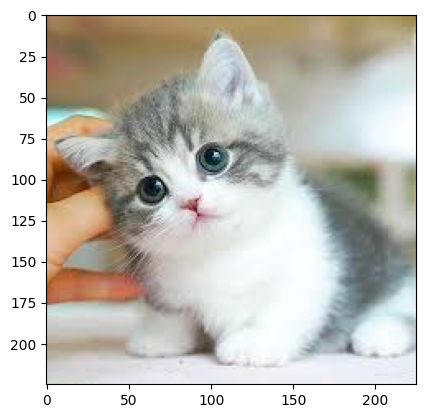

In [735]:
img = cv2.imread("images.jpg")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

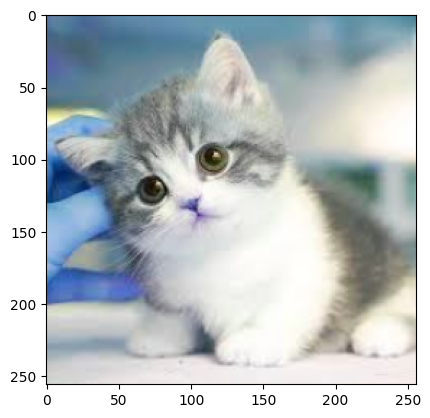

In [736]:
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize/255)

In [740]:
y_pred = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step


In [741]:
ans = list(y_pred[0]).index(max(list(y_pred[0])))
if ans == 0:
    print("Butterfly")
elif ans == 1:
    print("Cat")
elif ans == 2:
    print("dog")
elif ans == 3:
    print("horse")


Cat


In [742]:
y_pred

array([[3.0102933e-04, 8.6105698e-01, 7.7987753e-02, 6.0654253e-02]],
      dtype=float32)

In [743]:
print(y_pred)

[[3.0102933e-04 8.6105698e-01 7.7987753e-02 6.0654253e-02]]
